<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/Trabalho_Final_Draft_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Projeto Final - Mineração de Dados Complexos***

# 0) Setup

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.9361529189999942
GPU (s):
0.04908837299998936
GPU speedup over CPU: 39x


In [16]:
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd
import pickle

import tensorflow as tf
from IPython.display import SVG
#import efficientnet.tfkeras as efn
from tensorflow.keras.utils import plot_model
import tensorflow.keras.layers as L
#from tensorflow.keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50V2

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cmx


tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

import os

# 1) Importando bases do kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ericsuda","key":"30d8265b6f81dcfb2bcba05081127ac4"}'}

In [5]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 3.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=7dfbdf7b82f95a0a6064885d2f343b5051ef133547462b90b653fd1b1162f56d
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
! mkdir projeto_final

In [7]:
! kaggle competitions download -c plant-pathology-2021-fgvc8 -p "projeto_final/"

100% 14.9G/14.9G [02:43<00:00, 137MB/s]
100% 14.9G/14.9G [02:43<00:00, 97.8MB/s]


In [8]:
!unzip "projeto_final/plant-pathology-2021-fgvc8.zip" -d "/projeto_final/"

Streaming output truncated to the last 5000 lines.
  inflating: /projeto_final/train_images/e00c97b2de4749ce.jpg  
  inflating: /projeto_final/train_images/e00df890cfe62736.jpg  
  inflating: /projeto_final/train_images/e00ed0bf43a87f25.jpg  
  inflating: /projeto_final/train_images/e00f759d65d52887.jpg  
  inflating: /projeto_final/train_images/e00f934d9e50ad5b.jpg  
  inflating: /projeto_final/train_images/e00fce341cb63da5.jpg  
  inflating: /projeto_final/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /projeto_final/train_images/e01112939f783fec.jpg  
  inflating: /projeto_final/train_images/e01592da4d71b8be.jpg  
  inflating: /projeto_final/train_images/e0189acaf8cf80fd.jpg  
  inflating: /projeto_final/train_images/e0189e4999bdd0fa.jpg  
  inflating: /projeto_final/train_images/e01ae16d4a759cb5.jpg  
  inflating: /projeto_final/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /projeto_final/train_images/e01e42d90c66f3f3.jpg  
  inflating: /projeto_final/train_images/e01e870bec65

# 2) Exploração dos Dados

### Carregando os datasets

In [9]:
TEST_PATH = "../projeto_final/sample_submission.csv"
TRAIN_PATH = "../projeto_final/train.csv"

In [10]:
df_train = pd.read_csv(TRAIN_PATH)
df_test=pd.read_csv(TEST_PATH)

In [13]:
df_train["labels"].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

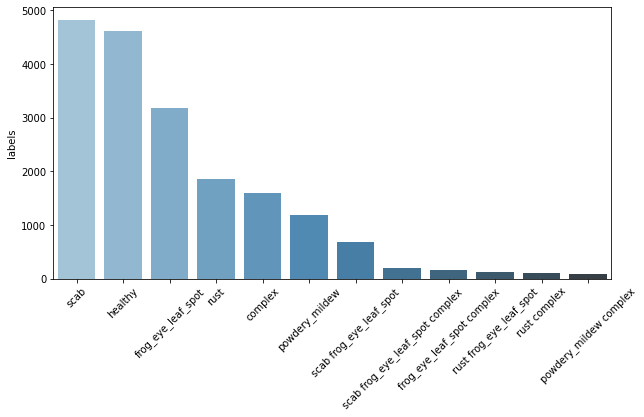

In [27]:
plt.figure(figsize=(10,5))
labels = sns.barplot(df_train.labels.value_counts().index,
                     df_train.labels.value_counts(),
                     palette="Blues_d")
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [31]:
! ls "../projeto_final/train_images/"

800113bb65efe69e.jpg  ad7fa47afcb20402.jpg  d66a0b1639ff64c0.jpg
8002cb321f8bfcdf.jpg  ad8084ecee24e6be.jpg  d66fcb790c992113.jpg
80070f7fb5e2ccaa.jpg  ad8085cfd8f16aaa.jpg  d67096507875e9b8.jpg
80077517781fb94f.jpg  ad815e2fcc295c2e.jpg  d67825d0f7d60155.jpg
800cbf0ff87721f8.jpg  ad81d5c53ae0cbb2.jpg  d67a54887a2f6135.jpg
800edef467d27c15.jpg  ad82b3d5bc456a38.jpg  d67a60d2f0d5d4c1.jpg
800f85dc5f407aef.jpg  ad8318c19b3eef84.jpg  d67cf43f202643e1.jpg
801d6dcd96e48ebc.jpg  ad8386e398adb564.jpg  d68031e7f14fc98c.jpg
801f78399a44e7af.jpg  ad859555ca6dc8a5.jpg  d6807e0d1dff0c51.jpg
8021b94d437eb7d3.jpg  ad864aca4ad57695.jpg  d680c9fc6c7731c1.jpg
802291cee9fec9f4.jpg  ad889a666e3439cb.jpg  d6842f96f23e0b2c.jpg
80230a9a3f7a9f6b.jpg  ad8940d07a7bae95.jpg  d685d4c728896fb8.jpg
8023c3f31f875b6c.jpg  ad8acab995b1e143.jpg  d685dee1702cf1c1.jpg
80261f473eafb92c.jpg  ad8ad1d20aef544e.jpg  d686f694c4daa4aa.jpg
80273091d9e9bddb.jpg  ad8addd454e14a6c.jpg  d6870090fd929f9d.jpg
802962dc3ecdbb8d.jpg  ad8

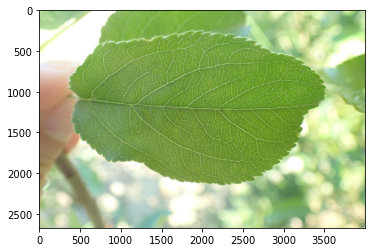

In [32]:
import matplotlib.image as mpimage
plt.figure(figsize=)
image = mpimage.imread("../projeto_final/train_images/ad7edea01843544f.jpg")
plt.imshow(image)
plt.show()